# Projet numérique de science des données - NOM 1 Prénom 1 et NOM 2 Prénom 2

## Introduction au projet

Il s'agit de construire un modèle prédisant le type de couvert végétal d'une parcelle de forêt (carré de 30m x 30m) à partir d'informations cartographiques décrivant cette parcelle.

Le but final sera d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette. __La note finale portera largement plus sur votre démarche (notebook et ses commentaires) que sur la qualité de vos prédictions.__ 

__Consignes :__ 
* Déclarez votre binôme en vous inscrivant dans un groupe de rendu de projet [sur Moodle](https://moodle.psl.eu/course/view.php?id=22890) afin de récupérer le fichier pour lequel vous devrez faire des prédictions.
* Vous devrez rendre, par groupe de projet :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms & prénoms__ dans le titre du notebook
* Vous avez jusqu'au __5 juillet midi heure de Paris__
* Déposez vos fichiers [sur Moodle](https://moodle.psl.eu/course/view.php?id=22890) dans la section dédiée (un seul rendu par binôme est nécessaire).

__Déroulé :__
* Les séances du lundi 17/06 (10h45-12h15) et lundi 01/07 (10h45-12h15) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 17/06 ; c'est indiqué le cas échéant.

## Données

### Description des données 
Le dossier `data/` contient un jeu de données nommé `couvert_vegetal_public.tsv`. Il contient les données étiquetées à partir desquelles construire votre modèle.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* variables continues :
  * `altitude` : altitude en mètres
  * `pente` : pente en degrés
  * `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
  * `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
  * `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
  * `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
  * `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
  * `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
  * `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* variables binaires
  * `zone_A` : 0 ou 1, selon si la parcelle appartient à une zone géographique A ou non
  * `couvert` (étiquette) : nature du couvert végétal (0 = sapin ou épicéa ; 1 = pin tordu)

### Chargement des données étiquetées

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import log2
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA

In [2]:
import pandas as pd

In [3]:
df_public = pd.read_csv('data/couvert_vegetal_public.tsv', delimiter='\t')

In [4]:
df_public.head()

,altitude,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,zone_A,couvert
0,2859,16,739,127,150,175,228,192,1590,0,1
1,3024,8,42,4,1261,205,246,179,957,0,1
2,3057,9,295,68,2581,198,230,171,1959,0,1
3,2802,12,120,14,446,240,223,112,2582,0,1
4,2880,20,190,71,1317,194,254,193,2698,0,1


In [5]:
df_public.tail()

,altitude,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,zone_A,couvert
4995,3162,10,283,13,6125,234,221,118,1113,1,0
4996,3155,13,268,6,6142,241,223,110,1121,1,0
4997,3149,16,256,0,6159,246,226,104,1129,1,0
4998,3139,19,247,-8,6176,247,226,99,1138,1,0
4999,3133,17,242,-15,6194,244,230,109,1148,1,0


### Visualisation des variables

#### Question 1
Visualisez chacun des descripteurs (_features_) sous la forme de deux histogrammes superposés (grâce à [pyplot.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)), l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative

__Conseils :__
* utilisez `df_public.loc[df_public["couvert"]==1]` pour obtenir les lignes de `df_public` pour lesquelles `couvert` vaut `1`.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

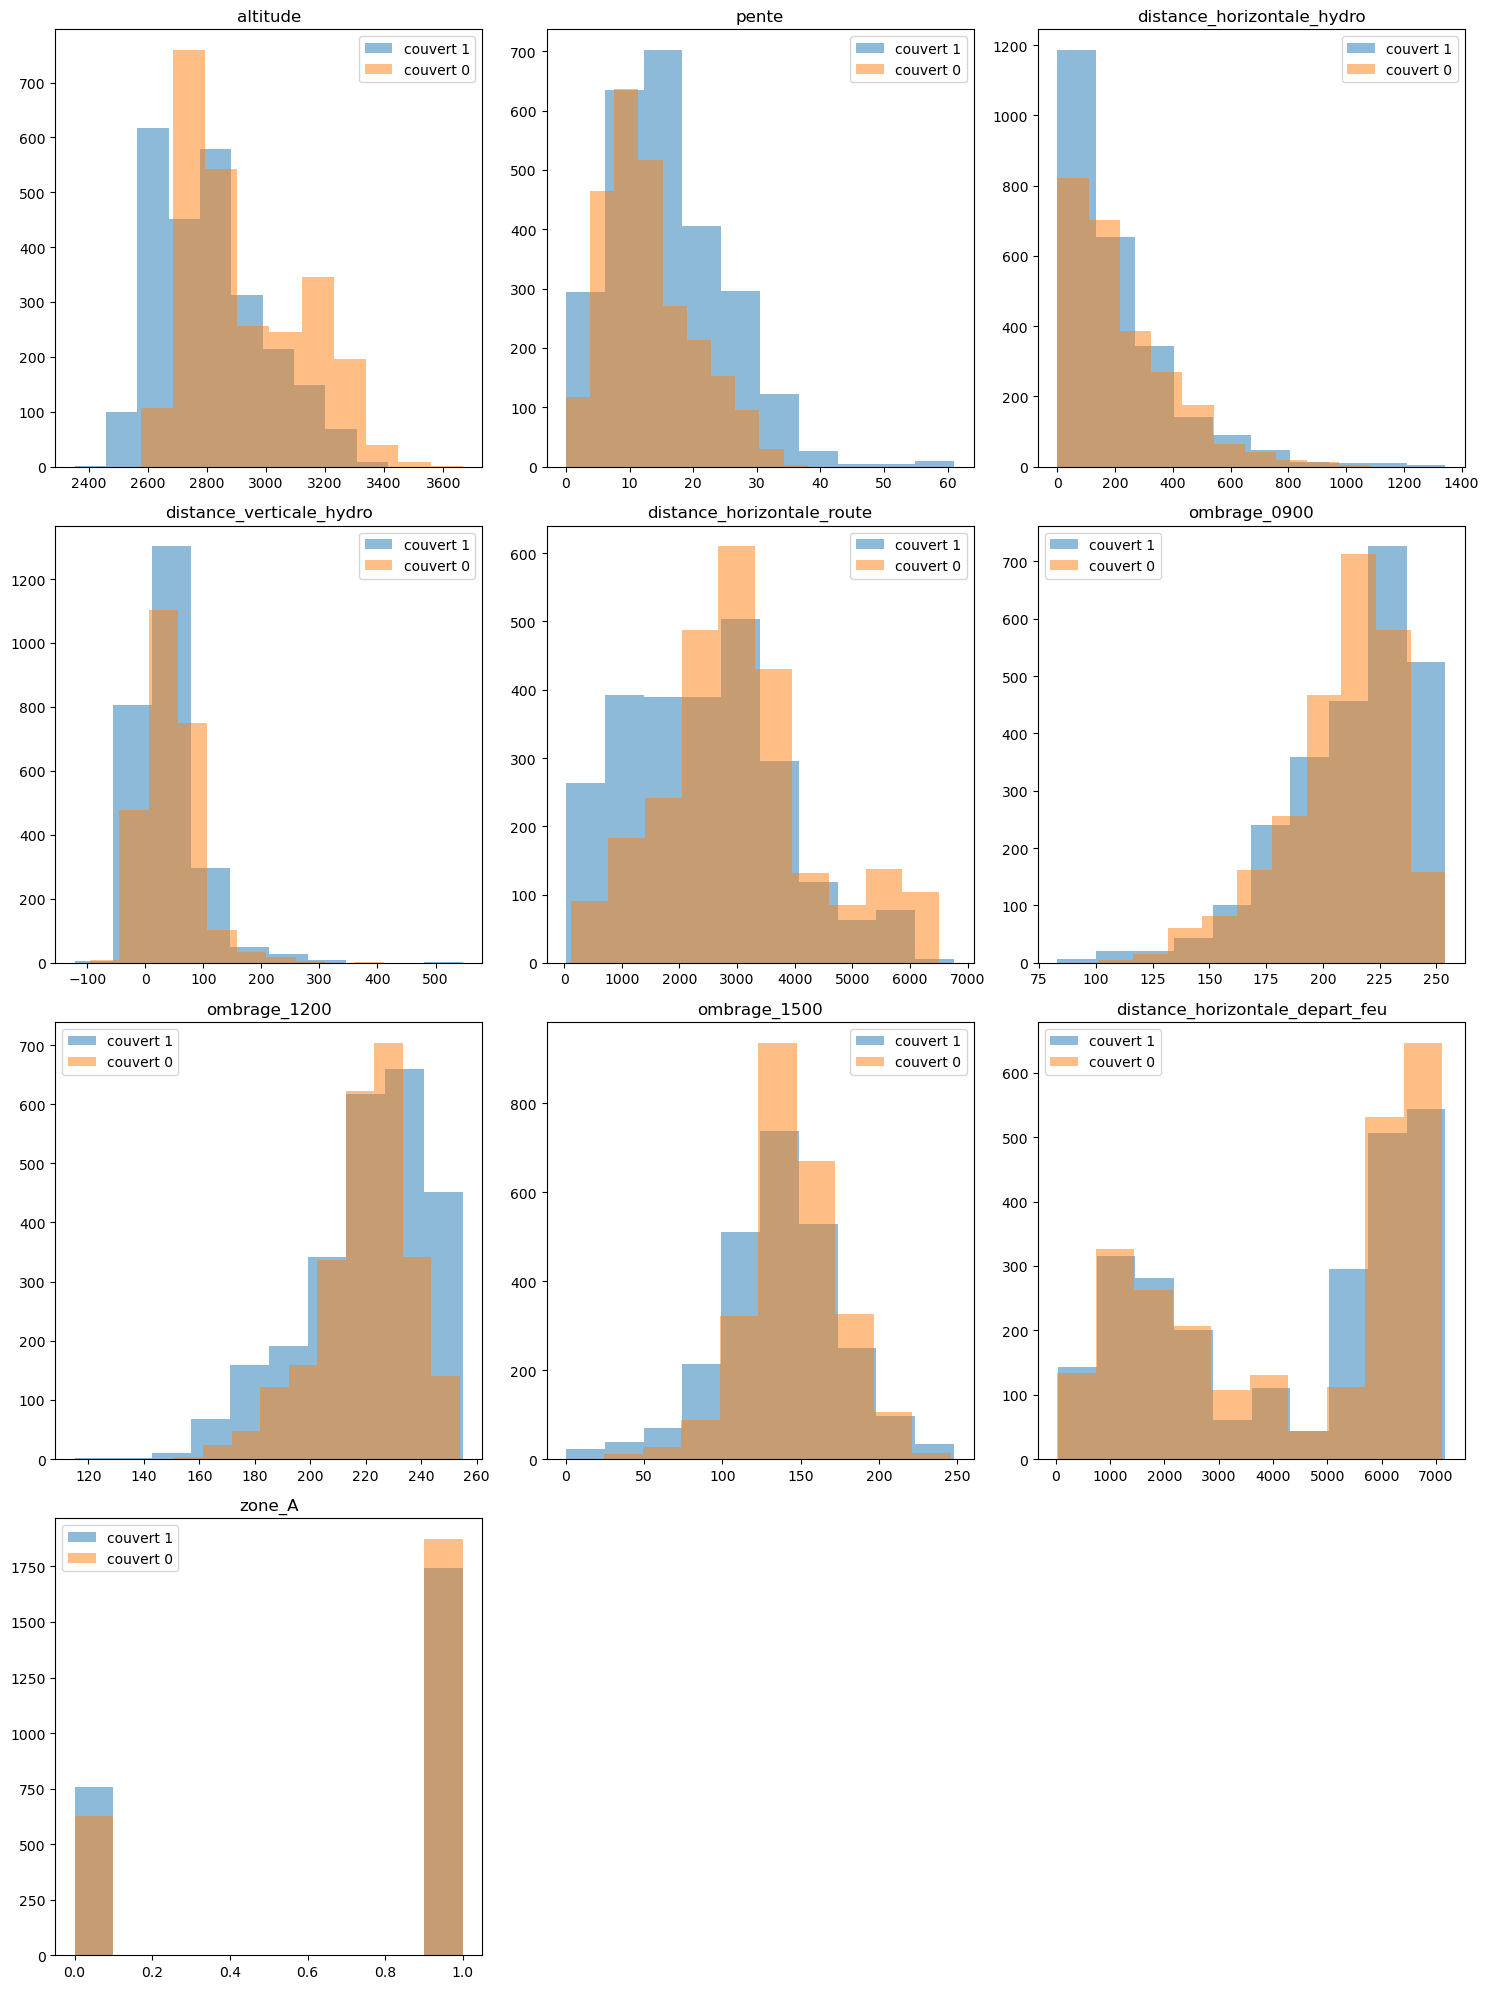

In [16]:
# xM = df_public["altitude"].max()
# xm = df_public["altitude"].min()
# k = int(1 + log2(df_public["altitude"].size))
# interval_size = (xM - xm) / k

df_public_1 = df_public.loc[df_public["couvert"]==1]
df_public_0 = df_public.loc[df_public["couvert"]==0]

categories = df_public.columns[:-1]

# Define the number of rows and columns for the subplots
n_categories = len(categories)
n_cols = 3
n_rows = (n_categories + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each category to plot histograms
for i, category in enumerate(categories):
    axs[i].hist(df_public_1[category], alpha=0.5, label="couvert 1")
    axs[i].hist(df_public_0[category], alpha=0.5, label="couvert 0")
    axs[i].set_title(category)
    axs[i].legend()

# Remove any empty subplots
for j in range(n_categories, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

Non, les différences entre les 2 jeux de données ne sont pas flagrantes.

### Visualisation en 2D

Commençons par extraire la matrice de design `X_public` (numpy.array) de `df_public` :

In [8]:
# Extraction de la matrice de design
X_public = np.array(df_public.drop(columns=["couvert"]))
etiquette = np.array(df_public["couvert"])
shadow_etiquette = 1 - etiquette

#### Question 3
a) Utilisez une ACP pour visualiser les données en deux dimensions. Plus précisément : utilisez une ACP des descripteurs (_features_) pour représenter les observations sous la forme d'un nuage de points en 2D, et colorez les points selon leur étiquette.

b) À quelle point cette ACP est-elle une représentation fidèle des données ? 

c) Pensez-vous maintenant qu'il va être aisé de distinguer les deux classes ? Pourquoi ?

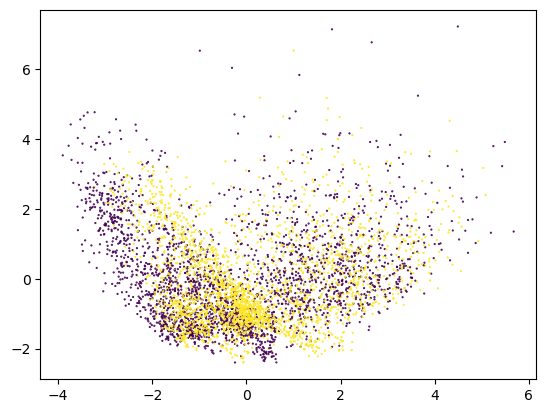

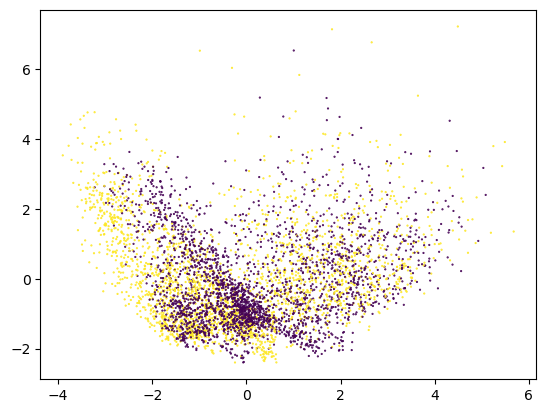

In [9]:
# a)
scaler = StandardScaler()
scaler.fit(X_public)
X = scaler.transform(X_public)


mypca = PCA(n_components = 2)
mypca.fit(X)

data_sortie = mypca.fit_transform(X)

plt.scatter(data_sortie[:,0], data_sortie[:,1], s = 0.3, c = shadow_etiquette)
plt.show()
plt.scatter(data_sortie[:,0], data_sortie[:,1], s = 0.3, c = etiquette)

## [À partir de la PC 3] Apprentissage supervisé

Nous allons maintenant avoir besoin du vecteur d'étiquettes `y_public` sous forme d'array numpy :

In [10]:
y_public = np.array(df_public["couvert"])

### Quantification des performances

Il existe de nombreux scores permettant d'évaluer les performances d'un algorithme de classification. Toutes celles implémentées dans scikit-learn sont listées [ici](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

Dans ce projet, nous allons utiliser la **proportion d'observations correctement classifiées**, ou _accuracy_ en anglais (à ne pas confondre avec la _precision_). Elle est implémentée par [metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) dans scikit-learn.

#### Question 4

a) Quel serait sur nos données l'accuracy d'un modèle naïf prédisant systématiquement la classe 1 ?

b) Supposons maintenant que le jeu de données sur lequel on évalue ce même modèle naïf comporte 9 fois plus d'exemples de la classe 1 que de la classe 0 (90% de `1`, 10% de `0`). Quel serait alors son accuracy ?

c) Quelle serait la [balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score) du modèle naïf sur le jeu de données de la question b) ?

### Algorithme des 7 plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=7.

#### Question 5

a) Utilisez la classe `KNeighborsClassifier` du module `neighbors` de `sklearn` pour entraîner un modèle avec l'algorithme des 7 plus proches voisins sur les données `(X_public, y_public)`.

Documentation : [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

b) Quelle est l'accuracy de ce modèle sur le jeu ayant servi à l'entraîner ?

In [11]:
from sklearn import metrics, neighbors

#### Pré-traitement des données

#### Question 6

Les variables du jeu de données prennent des valeurs sur des échelles différentes (voir par exemple `pente` vs `distance_horizontale_route` vs `zone_A`).

a) Quel effet cela peut-il avoir sur le calcul des plus proches voisins ?

b) Proposez et implémentez un pré-traitement permettant de remédier à ce problème : créez une nouvelle représentation des données publiques `X_public_preprocessed`, entraînez un algorithme des 7 plus proches voisins, et évaluez sa performance sur le jeu d'entraînement. 

#### Pré-traitement des données

#### Question 6

Les variables du jeu de données prennent des valeurs sur des échelles différentes (voir par exemple `pente` vs `distance_horizontale_route` vs `zone_A`).

a) Quel effet cela peut-il avoir sur le calcul des plus proches voisins ?

b) Proposez et implémentez un pré-traitement permettant de remédier à ce problème : créez une nouvelle représentation des données publiques `X_public_preprocessed`, entraînez un algorithme des 7 plus proches voisins, et évaluez sa performance sur le jeu d'entraînement. 

### [À partir de l'Amphi 6 / PC4] Mise en place d'une validation croisée 

Nous allons maintenant mettre en place une procédure de validation croisée pour évaluer/comparer différents modèles. Plus précisément, nous fixons le découpage du jeu de données en 5 _folds_, que nous réutiliserons pour chaque évaluation dans ce qui suit :

In [12]:
from sklearn import model_selection

In [13]:
n_folds = 5
kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=42)

### Algorithme des k plus proches voisins

#### Question 8 

a) Utilisez `kf` pour évaluer l'accuracy en validation croisée de l'algorithme des 7 plus proches voisins. 

b) Comparez à l'accuracy obtenue sur le jeu d'entraînement ; commentez.

#### Question 9

a) Évaluez la performance en validation croisée de l'algorithmes des k plus proches voisins, pour k variant de 1 à 19. Faites un graphe pour présenter les résultats.

b) Quelle valeur de k sélectionner pour faire des prédictions sur de nouvelles données ?

### Modèle linéaire 

#### Question 10

Évaluez l'accuracy en validation croisée d'une régression logistique sur le jeu d'entraînement. Sélectionnez le ou les hyperparamètres pertinents si nécessaire.

Comparez à l'accuracy du modèle de k plus proches voisins.

Documentation : [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [14]:
from sklearn import linear_model

### [À partir de l'Amphi 8] Modèle non-linéaire

#### Question 11

Choisissez un algorithme permettant d'apprendre un modèle de classification non-linéaire.

Évaluez son accuracy en validation croisée sur le jeu d'entraînement. Sélectionnez le ou les hyperparamètres pertinents si nécessaire.

Comparez aux accuracies obtenues jusqu'à présent.

### Choix du modèle final

#### Question 12
Étant donné le travail mené jusqu'à présent :

a) Quel algorithme d'apprentissage, avec quel(s) hyperparamètres, choisissez-vous pour apprendre votre modèle final ? 

b) Utilisez cet algorithme avec cet/ces hyperparamètres pour entraîner un  modèle `predictor_final` sur l'ensemble des données étiquetées. N'oubliez pas le pré-traitement si nécessaire.

## Prédictions

Vous recevrez après avoir déclaré votre binôme un jeu de données nommé `couvert_vegetal_prive_<n>.tsv` (ou `<n>` sera un numéro arbitraire). Il contient les données non-étiquetées, pour lesquelles faire vos prédictions. Le format est le même que pour `couvert_vegetal_public.tsv`, à l'exception de la variable `couvert`, que vous devrez prédire.

### Charger les données

Vous pouvez maintenant charger le jeu de données externe (en remplaçant `1` par le bon numéro) :

In [15]:
df_private = pd.read_csv('data/couvert_vegetal_prive_1.tsv', delimiter='\t')
X_private = np.array(df_private)

FileNotFoundError: [Errno 2] No such file or directory: 'data/couvert_vegetal_prive_1.tsv'

### Prédictions

#### Question 13
Utilisez `predictor_final` pour prédire les étiquettes des observations de `X_private`.  N'oubliez pas le pré-traitement si nécessaire. Enregistrez le résultat dans un array `y_pred_final`.

Vous pouvez maintenant utiliser le code suivant pour générer votre fichier de prédictions :

In [ ]:
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

__Attention !__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser un éditeur de texte simple, ou une commande bash type `less` ou `cat` ; ou alors assurez-vous de relancer la commande avant de soumettre vos prédictions.

## Pour aller plus loin

#### Bonus 1

Ajoutez le jeu de test à la visualisation de la question 3. Pensez-vous que les performances de votre modèle sur le jeu de test vont être
* aussi bonnes qu'en validation croisée sur le jeu d'entraînement ?
* meilleures ?
* moins bonnes ?

#### Bonus 2
La plupart des modèles de classification binaire retournent la valeur 0 ou 1 après seuillage d'un score qui est d'autant plus élevé que la probabilité que l'étiquette soit 1 est grande. (Certains algorithmes, comme la régression logistique, modélisent directement cette probabilité. D'autres, comme les SVM, retournent un score qui peut dépasser 1.) 

Ainsi peut se poser la question du choix du seuil à utiliser (par défaut, 0.5 quand on modélise une probabilité).

La **courbe ROC** fait partie des outils qui permettent de visualiser la performance d'un modèle _pour tous les seuils possibles_.
    
Dans scikit-learn, les méthodes `predict_proba()` retournent des prédictions non seuillés, tandis que les méthodes `predict()` retournent des prédictions binaires obtenues après seuillage. L'affichage des courbes ROC se fait grâce au module [metrics.plot_roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html).

Affichez (sur le même graphique) et comparez les courbes ROC pour les prédictions en validation croisée obtenues pour les différents modèles.

#### Bonus 3

Pour aller plus loin dans la visualisation des données :
* visualisez plus de 2 composantes principales, toujours par paires (PC3 vs PC1, PC3 vs PC2, etc.). Les classes vous semblent-elles facilement séparables ?
* visualisez et interprétez la contribution de chacune des variables à chaque composante principale. 

#### Bonus 4

Utilisez d'autres algorithmes non-linéaires.